In [1]:
!git clone https://github.com/theschoolofai/modular.git

Cloning into 'modular'...


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
from modular.transforms import CustomResnetTransforms
from modular.dataloader import Cifar10SearchDataset

In [4]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = CustomResnetTransforms.train_transforms(means, stds)
test_transforms = CustomResnetTransforms.test_transforms(means, stds)

In [5]:
train = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


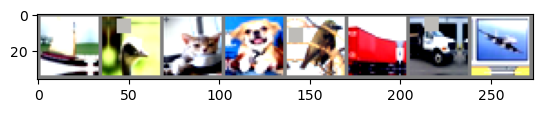

ship  bird  cat   dog  


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:8]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [8]:
from modular.model import CustomResNet
from modular.utils import print_summary, get_lr, get_device

In [9]:
_, device = get_device()
model = CustomResNet().to(device)
print_summary(model, device, (3, 32, 32))

Layer (type (var_name))                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
CustomResNet (CustomResNet)              --                        [20, 3, 32, 32]           [20, 10]                  --                        --                        True
├─Sequential (prep_layer)                --                        [20, 3, 32, 32]           [20, 64, 32, 32]          --                        --                        True
│    └─Conv2d (0)                        [3, 3]                    [20, 3, 32, 32]           [20, 64, 32, 32]          1,728                     35,389,440                True
│    └─BatchNorm2d (1)                   --                        [20, 64, 32, 32]          [20, 64, 32, 32]          128                       2,560                     True
│    └─ReLU (2)                          --                        [20, 64, 32, 32]          [20, 64, 32, 32]      

In [10]:
from modular.train import train, test

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.93E-02


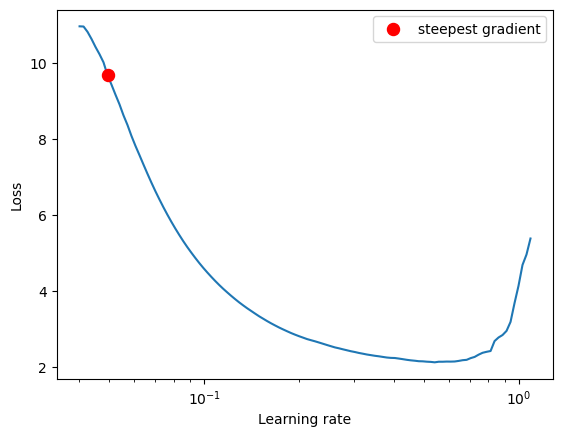

In [11]:
from torch_lr_finder import LRFinder

model = CustomResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [13]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr=4.93E-02,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler, criterion)
    test(model, device, test_loader, criterion)

EPOCH: 0


Loss=1.2500935792922974 LR=0.010274361963190183 Batch_id=97 Accuracy=48.60: 100%|██████████| 98/98 [00:14<00:00,  6.61it/s] 



Test set: Average loss: 0.0032, Accuracy: 4747/10000 (47.47%)

EPOCH: 1


Loss=1.092743158340454 LR=0.020055723926380366 Batch_id=97 Accuracy=62.06: 100%|██████████| 98/98 [00:14<00:00,  6.70it/s] 



Test set: Average loss: 0.0027, Accuracy: 6170/10000 (61.70%)

EPOCH: 2


Loss=0.8653668165206909 LR=0.02983708588957055 Batch_id=97 Accuracy=70.35: 100%|██████████| 98/98 [00:14<00:00,  6.79it/s] 



Test set: Average loss: 0.0020, Accuracy: 6774/10000 (67.74%)

EPOCH: 3


Loss=0.7064729928970337 LR=0.03961844785276073 Batch_id=97 Accuracy=74.53: 100%|██████████| 98/98 [00:14<00:00,  6.71it/s] 



Test set: Average loss: 0.0018, Accuracy: 6853/10000 (68.53%)

EPOCH: 4


Loss=0.5471314191818237 LR=0.04927352574113856 Batch_id=97 Accuracy=75.92: 100%|██████████| 98/98 [00:14<00:00,  6.68it/s] 



Test set: Average loss: 0.0015, Accuracy: 7421/10000 (74.21%)

EPOCH: 5


Loss=0.6414841413497925 LR=0.0466790483727175 Batch_id=97 Accuracy=76.86: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]  



Test set: Average loss: 0.0019, Accuracy: 6975/10000 (69.75%)

EPOCH: 6


Loss=0.6965605616569519 LR=0.044084571004296455 Batch_id=97 Accuracy=77.63: 100%|██████████| 98/98 [00:14<00:00,  6.54it/s]



Test set: Average loss: 0.0016, Accuracy: 7288/10000 (72.88%)

EPOCH: 7


Loss=0.6067644953727722 LR=0.0414900936358754 Batch_id=97 Accuracy=78.46: 100%|██████████| 98/98 [00:14<00:00,  6.66it/s]  



Test set: Average loss: 0.0015, Accuracy: 7320/10000 (73.20%)

EPOCH: 8


Loss=0.7275859117507935 LR=0.038895616267454344 Batch_id=97 Accuracy=79.24: 100%|██████████| 98/98 [00:14<00:00,  6.71it/s]



Test set: Average loss: 0.0016, Accuracy: 7274/10000 (72.74%)

EPOCH: 9


Loss=0.5059072375297546 LR=0.036301138899033296 Batch_id=97 Accuracy=79.62: 100%|██████████| 98/98 [00:14<00:00,  6.71it/s]



Test set: Average loss: 0.0016, Accuracy: 7298/10000 (72.98%)

EPOCH: 10


Loss=0.71603924036026 LR=0.03370666153061224 Batch_id=97 Accuracy=79.98: 100%|██████████| 98/98 [00:14<00:00,  6.82it/s]   



Test set: Average loss: 0.0015, Accuracy: 7406/10000 (74.06%)

EPOCH: 11


Loss=0.5330204963684082 LR=0.03111218416219119 Batch_id=97 Accuracy=79.78: 100%|██████████| 98/98 [00:14<00:00,  6.82it/s]  



Test set: Average loss: 0.0014, Accuracy: 7517/10000 (75.17%)

EPOCH: 12


Loss=0.5586426854133606 LR=0.028517706793770137 Batch_id=97 Accuracy=81.03: 100%|██████████| 98/98 [00:14<00:00,  6.79it/s] 



Test set: Average loss: 0.0014, Accuracy: 7528/10000 (75.28%)

EPOCH: 13


Loss=0.3954316973686218 LR=0.025923229425349085 Batch_id=97 Accuracy=81.50: 100%|██████████| 98/98 [00:14<00:00,  6.73it/s] 



Test set: Average loss: 0.0012, Accuracy: 8024/10000 (80.24%)

EPOCH: 14


Loss=0.6235834956169128 LR=0.023328752056928033 Batch_id=97 Accuracy=81.98: 100%|██████████| 98/98 [00:14<00:00,  6.77it/s] 



Test set: Average loss: 0.0014, Accuracy: 7687/10000 (76.87%)

EPOCH: 15


Loss=0.6290892958641052 LR=0.020734274688506985 Batch_id=97 Accuracy=82.69: 100%|██████████| 98/98 [00:14<00:00,  6.77it/s] 



Test set: Average loss: 0.0011, Accuracy: 8204/10000 (82.04%)

EPOCH: 16


Loss=0.4858856201171875 LR=0.01813979732008593 Batch_id=97 Accuracy=83.55: 100%|██████████| 98/98 [00:14<00:00,  6.98it/s]  



Test set: Average loss: 0.0011, Accuracy: 8035/10000 (80.35%)

EPOCH: 17


Loss=0.4756508767604828 LR=0.015545319951664874 Batch_id=97 Accuracy=84.06: 100%|██████████| 98/98 [00:14<00:00,  6.99it/s] 



Test set: Average loss: 0.0013, Accuracy: 7946/10000 (79.46%)

EPOCH: 18


Loss=0.3898036479949951 LR=0.012950842583243825 Batch_id=97 Accuracy=85.11: 100%|██████████| 98/98 [00:14<00:00,  6.93it/s] 



Test set: Average loss: 0.0010, Accuracy: 8306/10000 (83.06%)

EPOCH: 19


Loss=0.4098075330257416 LR=0.01035636521482277 Batch_id=97 Accuracy=86.21: 100%|██████████| 98/98 [00:13<00:00,  7.05it/s]  



Test set: Average loss: 0.0009, Accuracy: 8520/10000 (85.20%)

EPOCH: 20


Loss=0.3531365990638733 LR=0.007761887846401722 Batch_id=97 Accuracy=87.58: 100%|██████████| 98/98 [00:13<00:00,  7.00it/s] 



Test set: Average loss: 0.0008, Accuracy: 8713/10000 (87.13%)

EPOCH: 21


Loss=0.33556365966796875 LR=0.005167410477980666 Batch_id=97 Accuracy=89.09: 100%|██████████| 98/98 [00:13<00:00,  7.07it/s] 



Test set: Average loss: 0.0007, Accuracy: 8877/10000 (88.77%)

EPOCH: 22


Loss=0.2344292849302292 LR=0.002572933109559611 Batch_id=97 Accuracy=90.96: 100%|██████████| 98/98 [00:13<00:00,  7.05it/s]  



Test set: Average loss: 0.0006, Accuracy: 9024/10000 (90.24%)

EPOCH: 23


Loss=0.12769846618175507 LR=-2.154425886143757e-05 Batch_id=97 Accuracy=93.16: 100%|██████████| 98/98 [00:14<00:00,  7.00it/s]



Test set: Average loss: 0.0005, Accuracy: 9094/10000 (90.94%)

